**Aufgabe 40:**

Implementieren Sie einen ODE-Löser auf Basis eines beliebigen, expliziten linearen Mehrschrittverfahrens mit $k$ Schritten. Übergabeparameter sollten die Parameter $\alpha_0, \ldots, \alpha_{k−1}$ und $\beta_0, \ldots, \beta_{k−1}$, die Schrittweite $h$ sowie die notwendigen Daten zur Beschreibung des Anfangswertproblemes sein. Testen Sie Ihr Programm anhand einiger der bisher in den Übungen verwendeten Anfangswerprobleme und den expliziten Adams-Verfahren aus dem Vorlesungsskript. Zur Berechnung der benötigten Startwerte für das Mehrschrittverfahren verwenden Sie ein geeignetes Runge-Kutta Verfahren. Testen Sie auch das Beispiel Example 5.17 des Vorlesungsskriptes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# aus Aufgabe 31 ...

def RK4():
    
    """
        returns the butcher table of the 2-stage Gauss method
        consistency order ... 4
    """

    c = np.array([0, 1/2, 1/2, 1])
    A = np.array([[0,   0,   0, 0],
                  [1/2, 0,   0, 0],
                  [0,   1/2, 0, 0],
                  [0,   0,   1, 0]])
    b = np.array([1/6, 1/3, 1/3, 1/6])
    
    return c, A, b

# ---------------------------------------------------------------- #

def explicit_RK(f, y_0, t, butcher_tableau):
    
    """
        applies an explicit Runge-Kutta-Method
        returns approximation vector
        f ..... right hand side of ODE
                (should return numpy array)
        y_0 ... initial value of ODE
                (should be numpy array)
        t ..... time stamps, where to approximate
    """
    
    c, A, b = butcher_tableau
    m = len(c)
    
    # dimension of ODE
    n = len(y_0)
    
    # time steps
    h = t[1::] - t[:-1:]

    # number of time steps
    N = len(h)

    # potential approximation vector
    y = np.zeros((N+1, n))
    y[0] = y_0
    
    for ell in range(N):
        
        # increments
        k = np.zeros((m, n))
        
        for i in range(m):
            
            t_ = t[ell] + c[i] * h[ell]
            y_ = y[ell] + h[ell] * sum([A_ * k_ for A_, k_ in zip(A[i, :i-1:], k[:i-1:, :])])

            k[i] = f(t_, y_)
            
        Phi = sum([b_ * k_ for b_, k_ in zip(b, k)])
        y[ell + 1] = y[ell] + h[ell] * Phi
    
    return y.transpose()

# ---------------------------------------------------------------- #

def plot_ODE(t, y, title = 'Hier könnte Ihre Werbung stehen!'):

    """
        plots (approximation of) solution of ODE
        t ... time
        y ... solutions (as matrix)
    """

    fig = plt.figure()

    for i, y_ in enumerate(y):
        plt.plot(t, y_, label = '$y_{}$'.format(i+1))

    plt.xlabel('$t$')
    plt.ylabel('$y$')
    plt.legend()
    plt.suptitle(title)

    plt.grid(linestyle = ':')
    plt.show()

In [3]:
# ACHTUNG:
# In dem folgenden solver wird nicht mit Funktionsauswertungen gegeizt.
# Man könnte diese auch zwischenspeichern und somit mehr Effizient rausholen.
# So motiviert war ich dann doch wieder nicht!

def ODE_solver(alpha, beta, h, f, y_init, t_0, T):

    """
        This function approximates the solution of a given ODE with a given multi-step method.
        alpha .... characterizes multi-step method (last coefficient (not included here!) will be 1)
        beta ..... characterizes multi-step method (last coefficient (not included here!) will be 0)
        h ........ uniform step size
        f ........ right hand side of ODE
        y_init ... initial values of ODE
        t_0 ...... lower bound of interval
        T ........ upper bound of interval
    """

    # k-step method
    # dimension ODE
    k, n = y_init.shape

    # time nodes
    t = np.arange(t_0, T, h)

    # t_0, ..., t_N
    N = len(t) - 1

    y = np.zeros((N+1, n))
    y[:k] = y_init

    for ell in range(k-1, N):
        y[ell+1] = sum([h * beta[k-j] * f(t[ell+1-j], y[ell+1-j]) - alpha[k-j] * y[ell+1-j] for j in range(1, k+1)])

    return y.transpose()

In [4]:
def adams_bashforth(k):

    """
        This function returns the k-step Adams-Bashforth method.
    """
    
    alpha = None
    beta  = None

    if k == 1:

        alpha = np.array([-1, 1])
        beta  = np.array([ 1, 0])

    if k == 2:

        alpha = np.array([ 0, -1, 1])
        beta  = np.array([-1,  3, 0]) / 2

    if k == 3:

        alpha = np.array([0,  0, -1,  1])
        beta  = np.array([5, -16, 23, 0]) / 12

    if k == 4:

        alpha = np.array([ 0, 0,   0, -1,  1])
        beta  = np.array([-9, 37, -59, 55, 0]) / 24

    return alpha, beta

In [5]:
def Test(f, y_0, h, t_0, T):

    print("Resultat mit k-step Adams-Bashforth ...", '\n')

    for k in range(1, 5):

        print("k =", k)

        t = np.arange(t_0, T, h)
        butcher_tableau = RK4()

        y_init = explicit_RK(f, y_0, t[:k], butcher_tableau).transpose()

        alpha, beta = adams_bashforth(k)
        alpha = alpha[:-1:]
        beta  = beta [:-1:]

        y = ODE_solver(alpha, beta, h, f, y_init, t_0, T)
        plot_ODE(t, y)

    # ---------------- #

    print("Resultat mit 2-step Methode aus Example 5.17 ...", '\n')

    t = np.arange(t_0, T, h)
    butcher_tableau = RK4()

    y_init = explicit_RK(f, y_0, t[:2], butcher_tableau).transpose()

    alpha = np.array([-1, 6])
    beta  = np.array([ 3, 5])

    y = ODE_solver(alpha, beta, h, f, y_init, t_0, T)
    plot_ODE(t, y)

    # ---------------- #

    print("Resultat mit RK4-Verfahren ...", '\n')

    t = np.arange(t_0, T, h)
    butcher_tableau = RK4()
    y = explicit_RK(f, y_0, t, butcher_tableau)
    plot_ODE(t, y)

    # ---------------- #

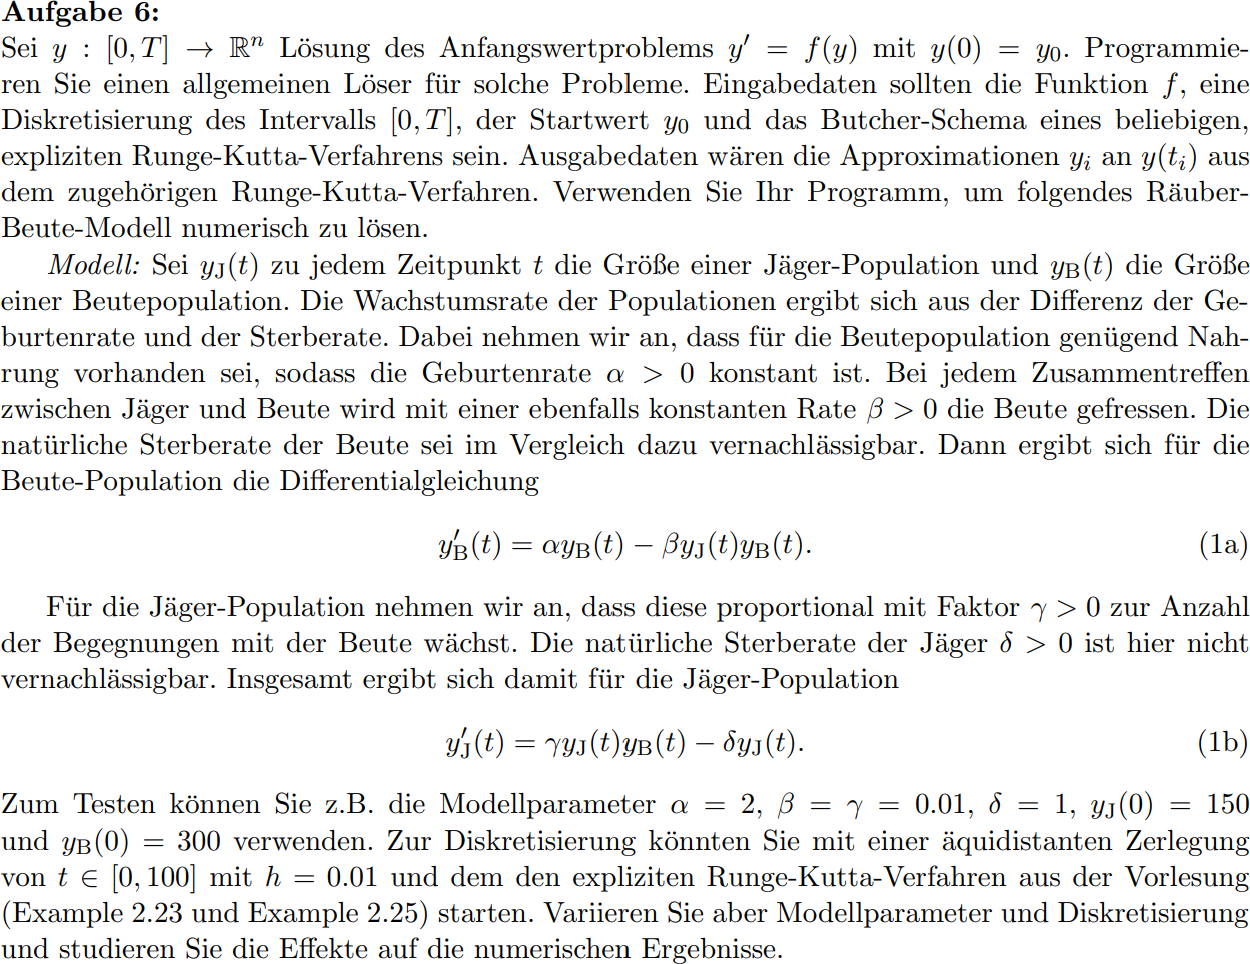

Resultat mit k-step Adams-Bashforth ... 

k = 1


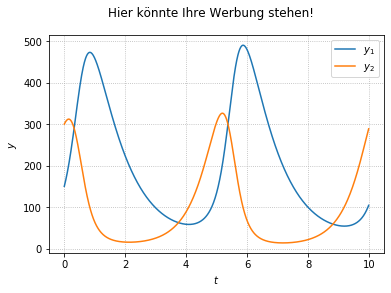

k = 2


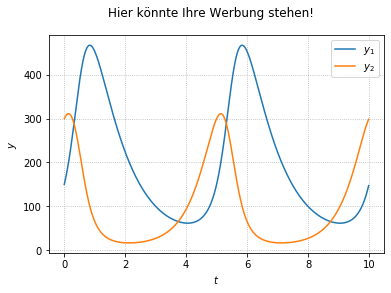

k = 3


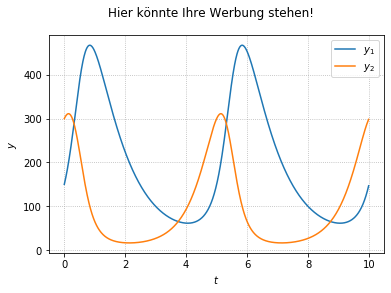

k = 4


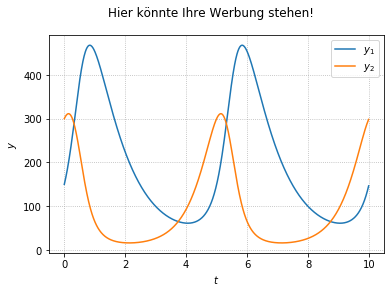

Resultat mit 2-step Methode aus Example 5.17 ... 



C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract


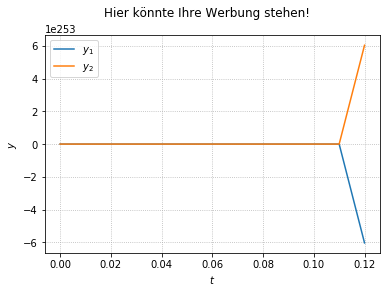

Resultat mit RK4-Verfahren ... 



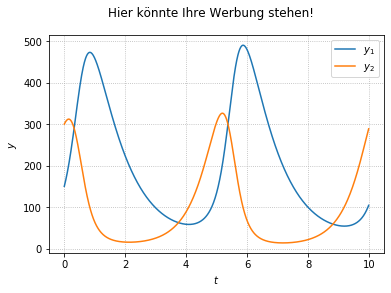

In [6]:
# Test mit dem Räuber-Beute-Modell aus Aufgabe 6

alpha = 2
beta  = 0.01
gamma = 0.01
delta = 1

def f(t, y):

    alpha = 2
    beta  = 0.01
    gamma = 0.01
    delta = 1

    predator = gamma * y[0] * y[1] - delta * y[0]
    prey     = alpha * y[1] - beta * y[0] * y[1]

    return np.array([predator, prey])

y_0 = np.array([150, 300])
h = 0.01

t_0 = 0
T   = 10

Test(f, y_0, h, t_0, T)

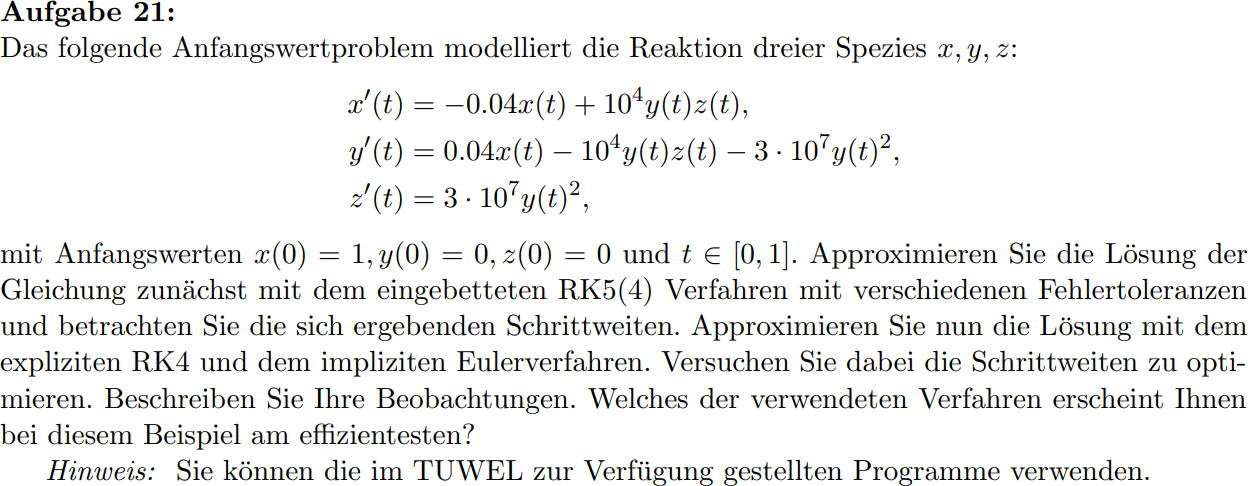

Resultat mit k-step Adams-Bashforth ... 

k = 1


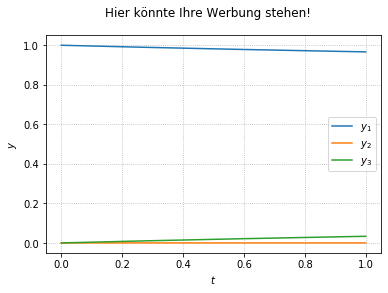

k = 2


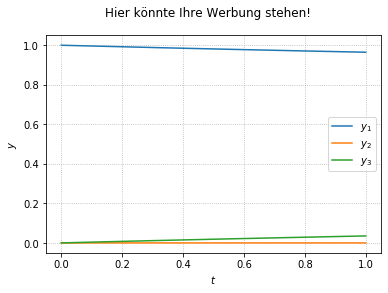

k = 3


C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in matmul
  # Remove the CWD from sys.path while we load stuff.


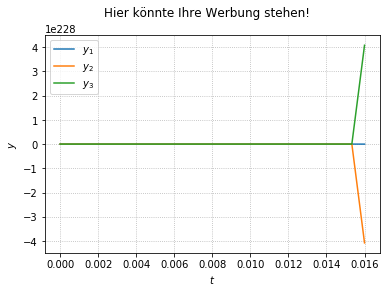

k = 4


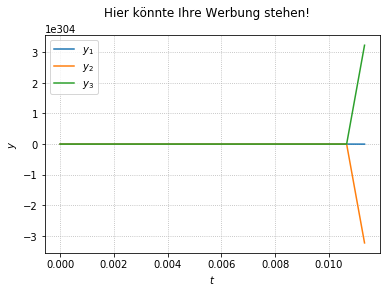

Resultat mit 2-step Methode aus Example 5.17 ... 



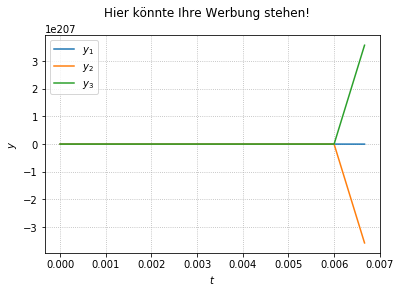

Resultat mit RK4-Verfahren ... 



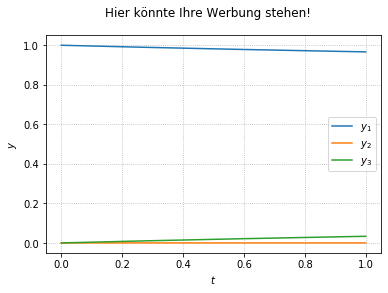

In [7]:
# Test mit der steifen ODE aus Aufgabe 21

def f(t, y):

    M = np.array([[-0.04,  1e4,  0  ],
                  [ 0.04, -1e4, -3e7],
                  [ 0,     0,    3e7]])
    v = np.array([y[0], y[1]*y[2], y[1]*y[1]])

    return M @ v

y_0 = np.array([1, 0, 0])

# this is interesting in combination with k
h = 1e-3 / 1.5

t_0 = 0
T   = 1

Test(f, y_0, h, t_0, T)